In [1]:
for i in range(0,1):
    import pybamm as pb
    import pandas as pd   
    import numpy as np
    import os
    import matplotlib.pyplot as plt
    from scipy.io import savemat,loadmat
    from pybamm import constants,exp,sqrt
    import matplotlib as mpl; fs=17;     # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
    mpl.rcParams["axes.labelsize"] = fs
    mpl.rcParams["axes.titlesize"] = fs
    mpl.rcParams["xtick.labelsize"] =  fs
    mpl.rcParams["ytick.labelsize"] =  fs
    mpl.rcParams["legend.fontsize"] =  fs
    mpl.rcParams['font.sans-serif'] = ['DejaVu Sans']
    mpl.rcParams['font.serif'] = ['DejaVu Sans']
    mpl.rcParams['axes.unicode_minus'] = False

In [2]:
# Define electrolyte diffusivity and conductivity
def electrolyte_diffusivity_Nyman2008(c_e, T):
    D_c_e = 8.794e-11 * (c_e / 1000) ** 2 - 3.972e-10 * (c_e / 1000) + 4.862e-10
    return D_c_e    
def electrolyte_conductivity_Nyman2008(c_e, T):
    sigma_e = (0.1297 * (c_e / 1000) ** 3 - 2.51 * (c_e / 1000) ** 1.5 + 3.329 * (c_e / 1000))
    return sigma_e

def electrolyte_conductivity_Valoen2005(c_e, T):   # valid concentration: 0~4000 mol/m3
    sigma_e = 0.1 * (-10.5 + 0.668*(1e-3*c_e) + 0.494*(1e-6*c_e**2) + 0.074*T - 0.0178*(1e-3*c_e)*T - 8.86e-4*(1e-6*c_e**2)*T - 6.96e-5*T**2 + 2.8E-5*(1E-3*c_e)*T**2 ) **2 * (1e-3*c_e)
    return sigma_e
def electrolyte_diffusivity_Valoen2005(c_e, T):
    D_c_e = 1e-4 * 10**(-4.43 - 54/(T - 229 - 0.005*c_e) - 2.2e-4 * c_e   )
    return D_c_e

def electrolyte_conductivity_Ecker2015(c_e, T):
    # mol/m^3 to mol/l
    cm = 1e-3 * c_e
    # value at T = 296K
    sigma_e_296 = 0.2667 * cm ** 3 - 1.2983 * cm ** 2 + 1.7919 * cm + 0.1726
    # Add temperature dependence
    E_k_e = 1.71e4
    C = 296 * exp(E_k_e / (constants.R * 296))
    sigma_e = C * sigma_e_296 * exp(-E_k_e / (constants.R * T)) / T
    return sigma_e.value
def electrolyte_diffusivity_Ecker2015(c_e, T):
    # mol/m^3 to mol/l
    cm = 1e-3 * c_e
    # value at T = 296K
    sigma_e_296 = 0.2667 * cm ** 3 - 1.2983 * cm ** 2 + 1.7919 * cm + 0.1726
    # add temperature dependence
    E_k_e = 1.71e4
    C = 296 * exp(E_k_e / (constants.R * 296))
    sigma_e = C * sigma_e_296 * exp(-E_k_e / (constants.R * T)) / T
    D_c_e = (constants.k_b / (constants.F * constants.q_e)) * sigma_e * T / c_e
    return D_c_e.value

def electrolyte_conductivity_Ding2001(c_e, c_EC,  T):
    # c_e is lithium ion concentration in electrolyte in mol/m3, need to change to mol/kg
    # also be careful that T here is deg, while others are K
    rho_electrolyte = 1300 # in kg/m3
    c_e_kg = c_e / rho_electrolyte     # in mol/kg 
    M_LiPF6 = 151.905/1000  # kg/mol
    M_EC = 88.062/1000  # kg/mol
    M_EMC = 104.104/1000 # kg/mol
    x_EC = 1 / (1+ ( rho_electrolyte - c_e*M_LiPF6 - c_EC*M_EC  )/M_EMC/c_EC   )
    kai = -3.37115 + 12.5608*c_e_kg - 7.89593*c_e_kg**2 + 3.51922*c_e_kg**3-1.15471*c_e_kg**4 +18.1863*x_EC - 6.22756*c_e_kg*x_EC - 13.6916*c_e_kg**2*x_EC +8.43904*c_e_kg**3*x_EC - 7.83732*x_EC**2 + 19.607*c_e_kg*x_EC**2  - 18.4529*c_e_kg**2*x_EC**2 -30.6369*x_EC**3 + 29.2*c_e_kg*x_EC**3 - 0.0429918*T + 0.180877*c_e_kg*T -0.0836202*c_e_kg**2*T + 0.0230098*c_e_kg**3*T + 0.195946*T*x_EC +0.0676686*c_e_kg*x_EC*T - 0.14134*c_e_kg**2*x_EC*T + 0.147429*x_EC**2*T  +0.173059*c_e_kg*x_EC**2*T - 0.51634*x_EC**3*T - 0.000223097*T**2 +0.000111233*c_e_kg*T**2 + 0.0000495286*c_e_kg**2*T**2  +0.000952777*x_EC*T**2 + 0.00117334 *c_e_kg*x_EC*T**2-0.000619157*x_EC**2*T**2 - 3.46897E-7*T**3 - 2.75041E-6*c_e_kg*T**3 -5.57653E-6*x_EC*T**3 
    return kai 

In [3]:
np.sqrt(2)

1.4142135623730951

In [16]:
# compare Landesfeind exp(initial) and constant 
def electrolyte_conductivity_base_Landesfeind2019_Constant(c_e, T, coeffs):
    # mol.m-3 -> mol.l
    c = (c_e<4000)*c_e / 1000 +  (c_e>4000)* 4 # Mark Ruihe 
    p1, p2, p3, p4, p5, p6 = coeffs
    A = p1 * (1 + (T - p2))
    B = 1 + p3 * np.sqrt(c) + p4 * (1 + p5 * np.exp(1000 / T)) * c
    C = 1 + c ** 4 * (p6 * np.exp(1000 / T))
    sigma_e = A * c * B / C  # mS.cm-1

    return sigma_e / 10

def electrolyte_diffusivity_base_Landesfeind2019_Constant(c_e, T, coeffs):
    # mol.m-3 -> mol.l
    c = (c_e<4000)*c_e / 1000 +  (c_e>4000)* 4 # Mark Ruihe 
    p1, p2, p3, p4 = coeffs
    A = p1 * np.exp(p2 * c)
    B = np.exp(p3 / T)
    C = np.exp(p4 * c / T)
    D_e = A * B * C * 1e-10  # m2/s

    return D_e

def electrolyte_TDF_base_Landesfeind2019_Constant(c_e, T, coeffs):
    c = (c_e<4000)*c_e / 1000 +  (c_e>4000)* 4 # Mark Ruihe 
    p1, p2, p3, p4, p5, p6, p7, p8, p9 = coeffs
    tdf = (
        p1
        + p2 * c
        + p3 * T
        + p4 * c ** 2
        + p5 * c * T
        + p6 * T ** 2
        + p7 * c ** 3
        + p8 * c ** 2 * T
        + p9 * c * T ** 2
    )
    return tdf

def electrolyte_transference_number_base_Landesfeind2019_Constant(c_e, T, coeffs):
    c = (c_e<4000)*c_e / 1000 +  (c_e>4000)* 4 # Mark Ruihe 
    p1, p2, p3, p4, p5, p6, p7, p8, p9 = coeffs
    tplus = (
        p1
        + p2 * c
        + p3 * T
        + p4 * c ** 2
        + p5 * c * T
        + p6 * T ** 2
        + p7 * c ** 3
        + p8 * c ** 2 * T
        + p9 * c * T ** 2
    )

    return tplus
def electrolyte_transference_number_EC_EMC_3_7_Landesfeind2019_Constant(c_e, T):
    """
    Transference number of LiPF6 in EC:EMC (3:7 w:w) as a function of ion
    concentration and temperature. The data comes from [1].

    References
    ----------
    .. [1] Landesfeind, J. and Gasteiger, H.A., 2019. Temperature and Concentration
    Dependence of the Ionic Transport Properties of Lithium-Ion Battery Electrolytes.
    Journal of The Electrochemical Society, 166(14), pp.A3079-A3097.

    Parameters
    ----------
    c_e: :class:`pybamm.Symbol`
        Dimensional electrolyte concentration
    T: :class:`pybamm.Symbol`
        Dimensional temperature

    Returns
    -------
    :class:`pybamm.Symbol`
        Electrolyte transference number
    """
    coeffs = np.array(
        [
            -1.28e1,
            -6.12,
            8.21e-2,
            9.04e-1,
            3.18e-2,
            -1.27e-4,
            1.75e-2,
            -3.12e-3,
            -3.96e-5,
        ]
    )

    return electrolyte_transference_number_base_Landesfeind2019_Constant(c_e, T, coeffs)

def electrolyte_TDF_EC_EMC_3_7_Landesfeind2019_Constant(c_e, T):
    """
    Thermodynamic factor (TDF) of LiPF6 in EC:EMC (3:7 w:w) as a function of ion
    concentration and temperature. The data comes from [1].

    References
    ----------
    .. [1] Landesfeind, J. and Gasteiger, H.A., 2019. Temperature and Concentration
    Dependence of the Ionic Transport Properties of Lithium-Ion Battery Electrolytes.
    Journal of The Electrochemical Society, 166(14), pp.A3079-A3097.

    Parameters
    ----------
    c_e: :class:`pybamm.Symbol`
        Dimensional electrolyte concentration
    T: :class:`pybamm.Symbol`
        Dimensional temperature

    Returns
    -------
    :class:`pybamm.Symbol`
        Electrolyte thermodynamic factor
    """
    coeffs = np.array(
        [2.57e1, -4.51e1, -1.77e-1, 1.94, 2.95e-1, 3.08e-4, 2.59e-1, -9.46e-3, -4.54e-4]
    )

    return electrolyte_TDF_base_Landesfeind2019_Constant(c_e, T, coeffs)

def electrolyte_diffusivity_EC_EMC_3_7_Landesfeind2019_Constant(c_e, T):
    """
    Diffusivity of LiPF6 in EC:EMC (3:7 w:w) as a function of ion concentration and
    temperature. The data comes from [1].

    References
    ----------
    .. [1] Landesfeind, J. and Gasteiger, H.A., 2019. Temperature and Concentration
    Dependence of the Ionic Transport Properties of Lithium-Ion Battery Electrolytes.
    Journal of The Electrochemical Society, 166(14), pp.A3079-A3097.

    Parameters
    ----------
    c_e: :class:`pybamm.Symbol`
        Dimensional electrolyte concentration
    T: :class:`pybamm.Symbol`
        Dimensional temperature

    Returns
    -------
    :class:`pybamm.Symbol`
        Electrolyte diffusivity
    """
    coeffs = np.array([1.01e3, 1.01, -1.56e3, -4.87e2])

    return electrolyte_diffusivity_base_Landesfeind2019_Constant(c_e, T, coeffs)

def electrolyte_conductivity_EC_EMC_3_7_Landesfeind2019_Constant(c_e, T):
    """
    Conductivity of LiPF6 in EC:EMC (3:7 w:w) as a function of ion concentration and
    temperature. The data comes from [1].

    References
    ----------
    .. [1] Landesfeind, J. and Gasteiger, H.A., 2019. Temperature and Concentration
    Dependence of the Ionic Transport Properties of Lithium-Ion Battery Electrolytes.
    Journal of The Electrochemical Society, 166(14), pp.A3079-A3097.

    Parameters
    ----------
    c_e: :class:`pybamm.Symbol`
        Dimensional electrolyte concentration
    T: :class:`pybamm.Symbol`
        Dimensional temperature

    Returns
    -------
    :class:`pybamm.Symbol`
        Electrolyte conductivity
    """
    coeffs = np.array([5.21e-1, 2.28e2, -1.06, 3.53e-1, -3.59e-3, 1.48e-3])

    return electrolyte_conductivity_base_Landesfeind2019_Constant(c_e, T, coeffs)

def electrolyte_conductivity_base_Landesfeind2019(c_e, T, coeffs):
    # mol.m-3 -> mol.l
    c = c_e / 1000 # Mark Ruihe 
    p1, p2, p3, p4, p5, p6 = coeffs
    A = p1 * (1 + (T - p2))
    B = 1 + p3 * np.sqrt(c) + p4 * (1 + p5 * np.exp(1000 / T)) * c
    C = 1 + c ** 4 * (p6 * np.exp(1000 / T))
    sigma_e = A * c * B / C  # mS.cm-1

    return sigma_e / 10

def electrolyte_diffusivity_base_Landesfeind2019(c_e, T, coeffs):
    # mol.m-3 -> mol.l
    c = c_e / 1000 # Mark Ruihe 
    p1, p2, p3, p4 = coeffs
    A = p1 * np.exp(p2 * c)
    B = np.exp(p3 / T)
    C = np.exp(p4 * c / T)
    D_e = A * B * C * 1e-10  # m2/s

    return D_e

def electrolyte_TDF_base_Landesfeind2019(c_e, T, coeffs):
    c = c_e / 1000 # Mark Ruihe 
    p1, p2, p3, p4, p5, p6, p7, p8, p9 = coeffs
    tdf = (
        p1
        + p2 * c
        + p3 * T
        + p4 * c ** 2
        + p5 * c * T
        + p6 * T ** 2
        + p7 * c ** 3
        + p8 * c ** 2 * T
        + p9 * c * T ** 2
    )
    return tdf

def electrolyte_transference_number_base_Landesfeind2019(c_e, T, coeffs):
    c = c_e / 1000 # Mark Ruihe 
    p1, p2, p3, p4, p5, p6, p7, p8, p9 = coeffs
    tplus = (
        p1
        + p2 * c
        + p3 * T
        + p4 * c ** 2
        + p5 * c * T
        + p6 * T ** 2
        + p7 * c ** 3
        + p8 * c ** 2 * T
        + p9 * c * T ** 2
    )

    return tplus
def electrolyte_transference_number_EC_EMC_3_7_Landesfeind2019(c_e, T):
    """
    Transference number of LiPF6 in EC:EMC (3:7 w:w) as a function of ion
    concentration and temperature. The data comes from [1].

    References
    ----------
    .. [1] Landesfeind, J. and Gasteiger, H.A., 2019. Temperature and Concentration
    Dependence of the Ionic Transport Properties of Lithium-Ion Battery Electrolytes.
    Journal of The Electrochemical Society, 166(14), pp.A3079-A3097.

    Parameters
    ----------
    c_e: :class:`pybamm.Symbol`
        Dimensional electrolyte concentration
    T: :class:`pybamm.Symbol`
        Dimensional temperature

    Returns
    -------
    :class:`pybamm.Symbol`
        Electrolyte transference number
    """
    coeffs = np.array(
        [
            -1.28e1,
            -6.12,
            8.21e-2,
            9.04e-1,
            3.18e-2,
            -1.27e-4,
            1.75e-2,
            -3.12e-3,
            -3.96e-5,
        ]
    )

    return electrolyte_transference_number_base_Landesfeind2019(c_e, T, coeffs)

def electrolyte_TDF_EC_EMC_3_7_Landesfeind2019(c_e, T):
    """
    Thermodynamic factor (TDF) of LiPF6 in EC:EMC (3:7 w:w) as a function of ion
    concentration and temperature. The data comes from [1].

    References
    ----------
    .. [1] Landesfeind, J. and Gasteiger, H.A., 2019. Temperature and Concentration
    Dependence of the Ionic Transport Properties of Lithium-Ion Battery Electrolytes.
    Journal of The Electrochemical Society, 166(14), pp.A3079-A3097.

    Parameters
    ----------
    c_e: :class:`pybamm.Symbol`
        Dimensional electrolyte concentration
    T: :class:`pybamm.Symbol`
        Dimensional temperature

    Returns
    -------
    :class:`pybamm.Symbol`
        Electrolyte thermodynamic factor
    """
    coeffs = np.array(
        [2.57e1, -4.51e1, -1.77e-1, 1.94, 2.95e-1, 3.08e-4, 2.59e-1, -9.46e-3, -4.54e-4]
    )

    return electrolyte_TDF_base_Landesfeind2019(c_e, T, coeffs)

def electrolyte_diffusivity_EC_EMC_3_7_Landesfeind2019(c_e, T):
    """
    Diffusivity of LiPF6 in EC:EMC (3:7 w:w) as a function of ion concentration and
    temperature. The data comes from [1].

    References
    ----------
    .. [1] Landesfeind, J. and Gasteiger, H.A., 2019. Temperature and Concentration
    Dependence of the Ionic Transport Properties of Lithium-Ion Battery Electrolytes.
    Journal of The Electrochemical Society, 166(14), pp.A3079-A3097.

    Parameters
    ----------
    c_e: :class:`pybamm.Symbol`
        Dimensional electrolyte concentration
    T: :class:`pybamm.Symbol`
        Dimensional temperature

    Returns
    -------
    :class:`pybamm.Symbol`
        Electrolyte diffusivity
    """
    coeffs = np.array([1.01e3, 1.01, -1.56e3, -4.87e2])

    return electrolyte_diffusivity_base_Landesfeind2019(c_e, T, coeffs)

def electrolyte_conductivity_EC_EMC_3_7_Landesfeind2019(c_e, T):
    """
    Conductivity of LiPF6 in EC:EMC (3:7 w:w) as a function of ion concentration and
    temperature. The data comes from [1].

    References
    ----------
    .. [1] Landesfeind, J. and Gasteiger, H.A., 2019. Temperature and Concentration
    Dependence of the Ionic Transport Properties of Lithium-Ion Battery Electrolytes.
    Journal of The Electrochemical Society, 166(14), pp.A3079-A3097.

    Parameters
    ----------
    c_e: :class:`pybamm.Symbol`
        Dimensional electrolyte concentration
    T: :class:`pybamm.Symbol`
        Dimensional temperature

    Returns
    -------
    :class:`pybamm.Symbol`
        Electrolyte conductivity
    """
    coeffs = np.array([5.21e-1, 2.28e2, -1.06, 3.53e-1, -3.59e-3, 1.48e-3])

    return electrolyte_conductivity_base_Landesfeind2019(c_e, T, coeffs)

c_e = np.linspace(1e-3,5000, 1000)
D_e_landes_AllT = [];   sigma_e_landes_AllT=[];
t0plus_e_landes_AllT=[];TDF_e_landes_AllT=[];
D_e_landes_AllT_cons = [];   sigma_e_landes_AllT_cons=[];
t0plus_e_landes_AllT_cons=[];TDF_e_landes_AllT_cons=[];
Temp = [10,25,40]; 
print(Temp)
for temp in Temp:
    D_e_landes_AllT_cons.append(
        electrolyte_diffusivity_EC_EMC_3_7_Landesfeind2019_Constant(c_e,temp+273.15))
    sigma_e_landes_AllT_cons.append(
        electrolyte_conductivity_EC_EMC_3_7_Landesfeind2019_Constant(c_e,temp+273.15))
    t0plus_e_landes_AllT_cons.append(
        electrolyte_transference_number_EC_EMC_3_7_Landesfeind2019_Constant(c_e,temp+273.15))
    TDF_e_landes_AllT_cons.append(
        electrolyte_TDF_EC_EMC_3_7_Landesfeind2019_Constant(c_e,temp+273.15))
    D_e_landes_AllT.append(
        electrolyte_diffusivity_EC_EMC_3_7_Landesfeind2019(c_e,temp+273.15))
    sigma_e_landes_AllT.append(
        electrolyte_conductivity_EC_EMC_3_7_Landesfeind2019(c_e,temp+273.15))
    t0plus_e_landes_AllT.append(
        electrolyte_transference_number_EC_EMC_3_7_Landesfeind2019(c_e,temp+273.15))
    TDF_e_landes_AllT.append(
        electrolyte_TDF_EC_EMC_3_7_Landesfeind2019(c_e,temp+273.15))

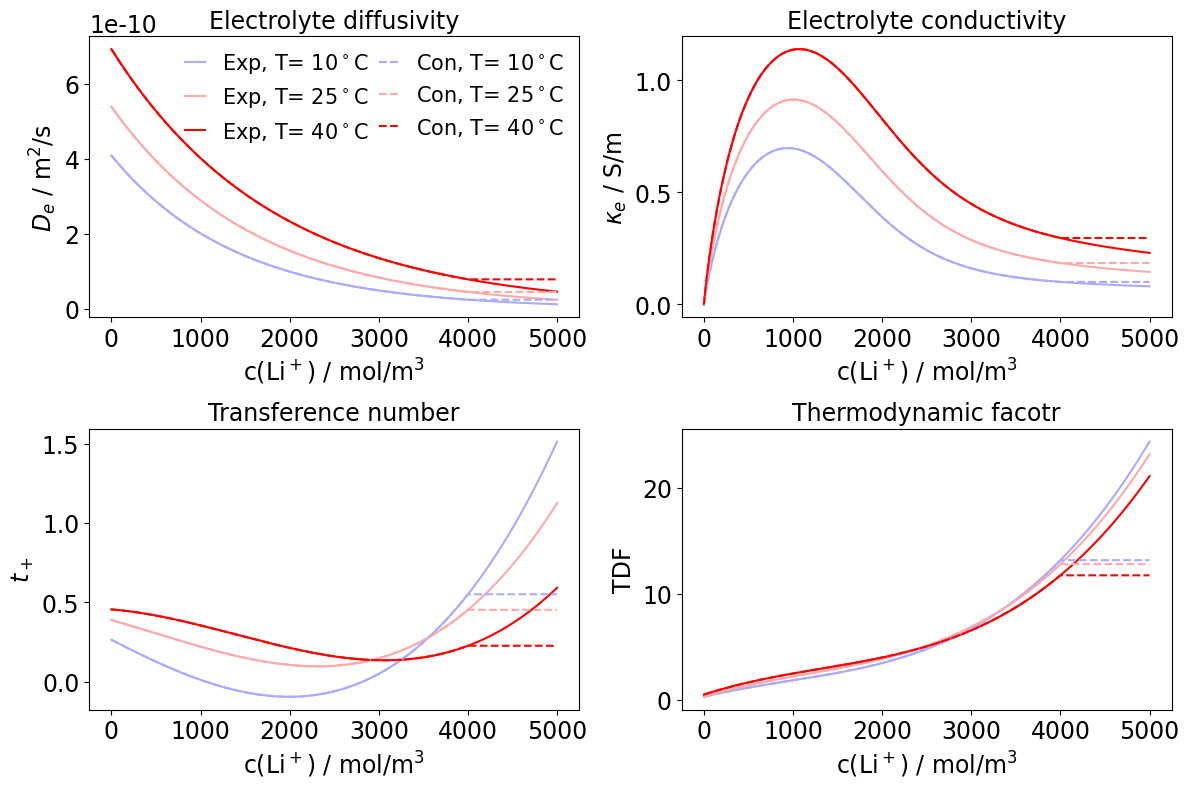

In [58]:
# plot to compare 
dpi=400
fig, axs = plt.subplots(2,2, figsize=(12,8),tight_layout=True)
cm = mpl.cm.get_cmap("bwr", 4)  
# 
for i in range(len(Temp)):
    axs[0,0].plot(c_e, D_e_landes_AllT[i],    '-',color=cm(i+1),label=f'Exp, T= {Temp[i]}'+r'$^\circ$C') # 
    axs[0,1].plot(c_e, sigma_e_landes_AllT[i],    '-',color=cm(i+1)) 
    axs[1,0].plot(c_e, t0plus_e_landes_AllT[i],    '-',color=cm(i+1)) 
    axs[1,1].plot(c_e, TDF_e_landes_AllT[i],    '-',color=cm(i+1)) 
for i in range(len(Temp)):
    axs[0,0].plot(c_e, D_e_landes_AllT_cons[i],    '--',color=cm(i+1),label=f'Con, T= {Temp[i]}'+r'$^\circ$C') # label=f'Cycle {cycles[i]}'
    axs[0,1].plot(c_e, sigma_e_landes_AllT_cons[i],    '--',color=cm(i+1)) 
    axs[1,0].plot(c_e, t0plus_e_landes_AllT_cons[i],    '--',color=cm(i+1)) 
    axs[1,1].plot(c_e, TDF_e_landes_AllT_cons[i],    '--',color=cm(i+1)) 
axs[0,0].legend(prop={'family':'DejaVu Sans','size':fs-2},
    loc='best',ncol=2,   # bbox_to_anchor=(1, 0.5),
    frameon=False,markerscale=1,borderpad=0.2,
    handlelength=1.0,columnspacing=0.5)
for i in range(0,2):
    for j in range(0,2):
        axs[i,j].set_xlabel(r'c(Li$^+$) / mol/m$^3$') 
axs[0,0].set_ylabel(r'$D_e$ / m$^2$/s') 
axs[0,1].set_ylabel(r'$\kappa_e$ / S/m') 
axs[1,0].set_ylabel(r'$t_+$') 
axs[1,1].set_ylabel(r'TDF') 
axs[0,0].set_title("Electrolyte diffusivity",loc='center') 
axs[0,1].set_title("Electrolyte conductivity",loc='center') 
axs[1,0].set_title("Transference number",loc='center') 
axs[1,1].set_title("Thermodynamic factor",loc='center') 

BasicPath = "D:/OneDrive - Imperial College London/SimDataSave/InputData/"
plt.savefig(BasicPath + "Compare Landes exp and const for GEM-2.png", dpi=dpi)